In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%load_ext autoreload
%autoreload 2

/Users/berekuk/.local/share/virtualenvs/core--9goXGUj/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
from kocherga.db import Session

INFO:kocherga.db:Creating an engine for mysql://root:@localhost/kocherga


In [3]:
from kocherga.cm import Order, Customer

In [4]:
df = pd.read_sql(Session().query(Order).statement, Session().bind)

In [5]:
df.head(2)

,order_id,card_id,start_ts,end_ts,imported_ts,log_imported_ts,people,visit_length,full_visit_length,order_value,time_value,stuff_value,payment_type,is_fixed,client_name,manager,tariff_time,tariff_plan,comment,history
0,1,1,1442688480,1442693100,1.539626e+09,1.528039e+09,1,76,76,152,152,0,Нал,нет,,Anny,Включен,,,"Открыт заказ, Заказ закрыт."
1,2,3,1442834580,1442840280,1.539626e+09,1.528039e+09,1,95,95,190,190,0,Нал,нет,Лях,admin,Включен,,,"Открыт заказ, Заказ закрыт."


In [6]:
df['start'] = pd.to_datetime(df['start_ts'], unit='s')

In [7]:
df['start'].head(3)

0   2015-09-19 18:48:00
1   2015-09-21 11:23:00
2   2015-09-21 17:45:00
Name: start, dtype: datetime64[ns]

In [8]:
df['period'] = df['start'].apply(lambda x: x.strftime('%Y-%m'))

In [9]:
df['period'].head(3)

0    2015-09
1    2015-09
2    2015-09
Name: period, dtype: object

In [10]:
df = df[df['client_name'] != '']

In [11]:
df2 = df.reindex(columns=['order_id', 'card_id', 'start', 'period', 'people', 'visit_length', 'order_value', 'time_value'])

In [12]:
df2.set_index('card_id', inplace=True)
df2['CohortGroup'] = df2.groupby(level=0)['start'].min().apply(lambda x: x.strftime('%Y-%m'))
df2.reset_index(inplace=True)

In [13]:
df2.head(3)

,card_id,order_id,start,period,people,visit_length,order_value,time_value,CohortGroup
0,3,2,2015-09-21 11:23:00,2015-09,1,95,190,190,2015-09
1,4,9,2015-09-22 20:27:00,2015-09,1,110,220,220,2015-09
2,5,10,2015-09-22 21:26:00,2015-09,1,79,158,158,2015-09


In [14]:
grouped = df2.groupby(['CohortGroup', 'period'])

In [15]:
cohorts = grouped.agg({'card_id': pd.Series.nunique, 'order_id': pd.Series.nunique, 'order_value': np.sum})
cohorts = cohorts.rename(columns={'card_id': 'total_users', 'order_id': 'total_orders', 'order_value': 'total_income'})

In [16]:
cohorts.tail(21)

total_users  total_orders  total_income
CohortGroup period                                          
2018-05     2018-05           24            60         19420
            2018-06           13            36          9400
            2018-07           10            38         14550
            2018-08           12            40         10370
            2018-09           12            44          7190
            2018-10            7            33          5730
2018-06     2018-06           20            33         11300
            2018-07           13            60         11520
            2018-08           10            63          8990
            2018-09            8            71          5690
            2018-10            9            32          2550
2018-07     2018-07           31            74         19360
            2018-08           10            36          3310
            2018-09           10            25          3340
            2018-10            2            12             0
2018-08     2018-08           51           101         43210
            2018-09           17            64         16380
            2018-10            8            18          7970
2018-09     2018-09           56           133         44345
            2018-10           27            63         14090
2018-10     2018-10           40            63         21437

In [17]:
def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df
cohorts = cohorts.groupby(level=0).apply(cohort_period)

In [18]:
cohorts.tail(21)

total_users  total_orders  total_income  CohortPeriod
CohortGroup period                                                        
2018-05     2018-05           24            60         19420             1
            2018-06           13            36          9400             2
            2018-07           10            38         14550             3
            2018-08           12            40         10370             4
            2018-09           12            44          7190             5
            2018-10            7            33          5730             6
2018-06     2018-06           20            33         11300             1
            2018-07           13            60         11520             2
            2018-08           10            63          8990             3
            2018-09            8            71          5690             4
            2018-10            9            32          2550             5
2018-07     2018-07           31            74         19360             1
            2018-08           10            36          3310             2
            2018-09           10            25          3340             3
            2018-10            2            12             0             4
2018-08     2018-08           51           101         43210             1
            2018-09           17            64         16380             2
            2018-10            8            18          7970             3
2018-09     2018-09           56           133         44345             1
            2018-10           27            63         14090             2
2018-10     2018-10           40            63         21437             1

In [33]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)
cohort_group_size = cohorts['total_users'].groupby(level=0).first()

In [34]:
cohort_group_size.tail(6)

CohortGroup
2018-05    24
2018-06    20
2018-07    31
2018-08    51
2018-09    56
2018-10    40
Name: total_users, dtype: int64

In [35]:
cohorts.tail(21)

period  total_users  total_orders  total_income
CohortGroup CohortPeriod                                                  
2018-05     1             2018-05           24            60         19420
            2             2018-06           13            36          9400
            3             2018-07           10            38         14550
            4             2018-08           12            40         10370
            5             2018-09           12            44          7190
            6             2018-10            7            33          5730
2018-06     1             2018-06           20            33         11300
            2             2018-07           13            60         11520
            3             2018-08           10            63          8990
            4             2018-09            8            71          5690
            5             2018-10            9            32          2550
2018-07     1             2018-07           31            74         19360
            2             2018-08           10            36          3310
            3             2018-09           10            25          3340
            4             2018-10            2            12             0
2018-08     1             2018-08           51           101         43210
            2             2018-09           17            64         16380
            3             2018-10            8            18          7970
2018-09     1             2018-09           56           133         44345
            2             2018-10           27            63         14090
2018-10     1             2018-10           40            63         21437

In [42]:
user_retention_percentage = cohorts['total_users'].unstack(0).divide(cohort_group_size, axis=1)
orders_retention_percentage = cohorts['total_orders'].unstack(0).divide(cohort_group_size, axis=1)
user_retention = cohorts['total_users'].unstack(0)
orders_retention = cohorts['total_orders'].unstack(0)
income_retention = cohorts['total_income'].unstack(0)

Text(0, 0.5, '% of Cohort Purchasing')

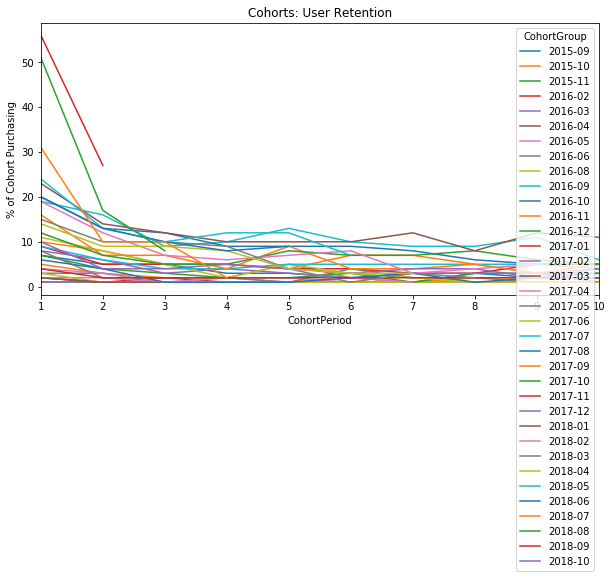

In [25]:
user_retention.head(10).plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 50., 1))
plt.xlim(1, 10)
plt.ylabel('% of Cohort Purchasing')

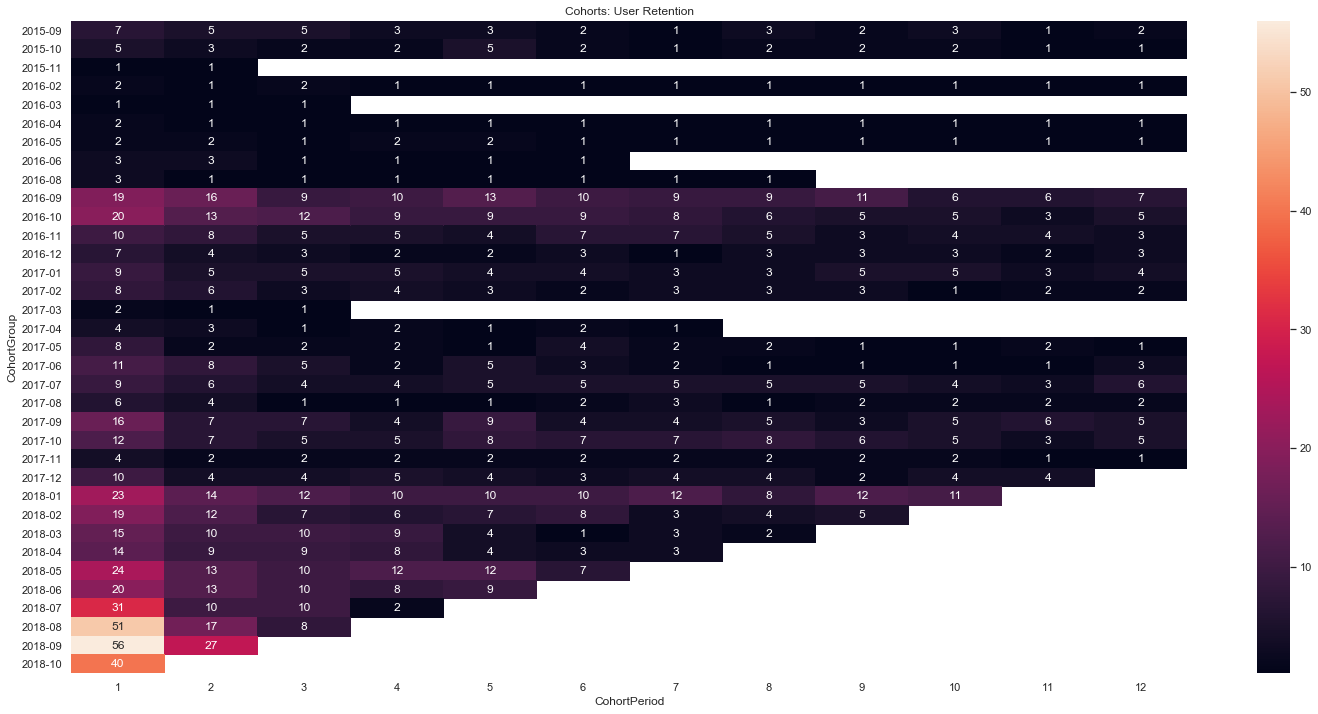

In [48]:
import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(25, 12))
plt.title('Cohorts: User Retention')
# sns.heatmap(user_retention.head(10).T, mask=user_retention.head(10).T.isnull(), annot=True, fmt='.0%')
# sns.heatmap(orders_retention_percentage.head(10).T, mask=user_retention_percentage.head(10).T.isnull(), annot=True, fmt='.0%')
sns.heatmap(user_retention.head(12).T, mask=user_retention_percentage.head(12).T.isnull(), annot=True, fmt='.0f')